# MSM Simulation Study Analysis File


In [ ]:
# import modules for math and distributions
#from math import exp
import numpy as np
#from scipy.stats import gamma, norm, uniform, bernoulli
import pandas as pd
#import statsmodels.api as sm
import rpy2
import patsy
import pdb
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# required to be able to work with rpy2
%load_ext rpy2.ipython

In [3]:
# Initial set up following HD2012
T = 40 # time periods
k = 5 # check-up times
theta = [-0.405, 0.0205, -0.00405]
gam = [-3, 0.05, -1.5, 0.1]

In [27]:
# import simulation functions and generate data for 1000 patients
import simulation_functions as sf
df = sf.sim_n(T, k, gam, theta, n=1000, lower=0, prop=1)

# Exploratory Analysis

Choose values of upper and lower to create a stratum of CD4 count (L) in which a patient never commences treatment, or always commences treatment.
The default is lower = 0 and upper = inf which is the no positivity case. Later in this notebook we look at positivity where introduce positivity into the data and compare the three approaches under the positivity assumption and when it is violated.

In [68]:
# make a status variable
tmp = df
x = tmp.groupby(level="patid")['A'].cumsum()
tmp["status"] = np.where(x == 0, "no treat", "x")
tmp["status"] = np.where(x == 1, "commence treat", tmp["status"])
tmp["status"] = np.where(x > 1, "treat", tmp["status"])
np.unique(set(tmp["status"]))
tmp["status"].value_counts()
tmp = df.reset_index()
tmp = tmp[tmp["visit"] % 5 == 0]
np.unique(set(tmp[["status", "visit"]]))
tmp["status"].value_counts()
# tmp = tmp[["patid", "visit", "status"]]
# tmp = tmp.set_index(['visit', 'status'])
# tmp = tmp.groupby(level=['visit', 'status']).count()
# tmp

treat             189
no treat          117
commence treat     75
Name: status, dtype: int64

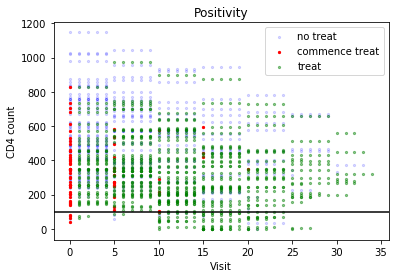

In [56]:
n = 100
lower = 100
frames = [sim(T, k, gam, theta, patid=i, lower=lower, prop=1) for i in range(n)]
tmp = pd.concat(frames)

tmp = tmp.set_index(['patid', 'visit'])
tmp = tmp.sort_index()
tmp["status"] = tmp.groupby(level="patid")['A'].cumsum()
tmp["status"] = np.where(tmp["status"] == 0, 0, tmp["status"])
tmp["status"] = np.where(tmp["status"] == 1, 1, tmp["status"])
tmp["status"] = np.where(tmp["status"] > 1, 2, tmp["status"])
tmp = tmp.reset_index()

#plot for each status
uniq = list(set(tmp['status']))
label = ["no treat", "commence treat", "treat"]
color = ["blue", "red", "green"]
alpha = [.15, 1, 0.45]
for i in range(len(uniq)):
    indx = tmp['status'] == uniq[i]
    plt.scatter(tmp.loc[indx, "visit"], tmp.loc[indx, "L"],
                s = 5, label=label[i], alpha = alpha[i],
               color = color[i])

plt.axhline(y=lower, color='black', linestyle='-')
plt.xlabel('Visit')
plt.ylabel('CD4 count')
plt.title('Positivity')
plt.legend(loc=1)
plt.show()


In [88]:
# plot across visits of percentage on treatment, not on treatment etc.
tmp2 = tmp[tmp["visit"] % 5 == 0]
tmp2 = tmp2.set_index(['patid', 'visit'])
tmp2 = tmp2.sort_index()
tmp3 = tmp2.groupby(level="visit")["status"].value_counts()
tmp3 = tmp3.to_frame()
#ax = sns.barplot(x="visit", y="total_bill", data=tmp3)

Index(['status'], dtype='object')

# Regression Variables
Following Havercroft, Didelez (2012) we define the variables used in the estimation of the hazard function

In [28]:
# make new variables for the logit regression
# including an intercept
def make_vars(df):
    df = df.reset_index()
    df["d1"] = (1-df['A'])*df['visit'] + df['A']*df['Ts']
    df["d3"] = df['A']*(df['visit']-df['Ts'])
    df = df.set_index(['patid', 'visit'])
    df = df.sort_index()
    return(df)

In [29]:
# a function to allow us to use the ipw package from R to get weights.
# The numerator and denominator probabilities of the stabilized weights
# are estimated using a coxph model.
import rpy2.robjects as robjects
robjects.r('''
       runreg <- function(tmp){
       library(ipw)
       library(survey)
       tmp$tstart <- tmp$visit - 1
       ipwsw <- ipwtm(exposure = A, family = "survival", # survival model for weights
       numerator = ~ 1, denominator = ~ L,
       id = patid, timevar = visit, tstart = tstart,
       type = "first", data = tmp)
       tmp$ipwsw <- ipwsw$ipw.weights
       #desipw <- svydesign(ids = ~ 1, data = tmp, weights = ~ ipwsw)
       #mdl <- svyglm(Y ~ d1 + A + d3, design = desipw, family = quasibinomial())
       mdl <- glm(Y ~ d1 + A + d3, data = tmp, weights=ipwsw, family=binomial)
       return(coef(mdl))
       }
''')

# "initializes" function
r_runreg = robjects.globalenv['runreg'] 

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x0000000006BC14C8 / R:0x00000000143594F8>
[-2.823815, 0.042474, -1.469325, 0.100713]

# Positivity Violation
We investigate how the bias of the IPW estimates varies depending on the size of the lower threshold, below which patients are always treated.

In [13]:
# We want to ivestigate how the bias changes 
# as the lower limit changes.
threshold = [10 + 10*i for i in range(20)]

In [14]:
# Monte Carlo of table 1 in Havercroft, Didelez (2012) with
# positivity violation at different levels of lower threshold. 
B = 5 # number of replications
mt = np.zeros((len(threshold))) # average at each threshold.
for i in range(len(threshold)):
    mb = np.zeros((B, 4))
    for b in range(B):
        df = get_sim_data(T, k, gam, theta, n = 1000, lower=threshold[i])
        df = get_weights(df)
        tmp = df.reset_index()
        mb[b] = r_runreg(tmp)
    mt[i] = mb[:,2].mean(axis = 0)

In [15]:
bias = np.ndarray.tolist(mt + 1.5) # true parameter is -1.5
df = np.vstack((bias, threshold))
df = pd.DataFrame(df.T, columns=['bias', 'threshold'])

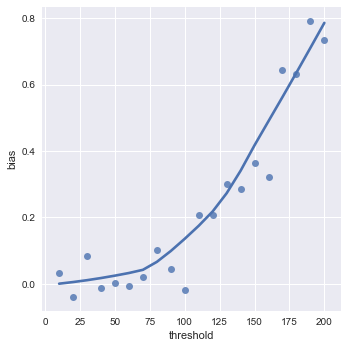

In [19]:
import seaborn as sns
sns.lmplot(x="threshold", y="bias", data=df, lowess=True)
plt.show()

# Proportion of positivity compliant doctors
We consider the case where there are two types of doctors. On the one hand there is a proportion p of doctors who rigidly positivity compliant. On the other hand there are doctors who are not positivity compliant, in such a way that elow a fixed lower bound of CD4 count they always treat. A drawback is that we assume all doctors are the same and choose a threshold t at which they treat a patient. Instead we could model the threshold as a function of the health of the patient using U0.

In [96]:
upper = 100
prop = [(i)*0.1 for i in range(11)]

In [102]:
# Monte Carlo of table 1 in Havercroft, Didelez (2012) with
# positivity violation at different levels of lower threshold. 
B = 10 # number of replications
mp = np.zeros((len(prop))) # average at each threshold.
for i in range(len(prop)):
    mb = np.zeros((B, 4))
    for b in range(B):
        df = get_sim_data(T, k, gam, theta, n = 1000, lower=100, prop=prop[i])
        df = get_weights(df)
        tmp = df.reset_index()
        mb[b] = r_runreg(tmp)
    mp[i] = mb[:,2].mean(axis = 0)

In [103]:
bias = np.ndarray.tolist(mp + 1.5) # true parameter is -1.5
df = np.vstack((bias, prop))
df = pd.DataFrame(df.T, columns=['bias', 'prop'])

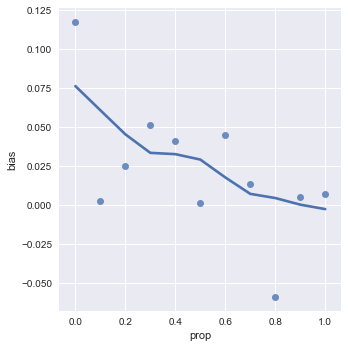

In [104]:
import seaborn as sns
sns.lmplot(x="prop", y="bias", data=df, lowess=True)
plt.show()